# Projeto IA - Sentiment Analysis em Tweets <hr>

### Título: Sentiment140 dataset with 1.6 million tweets (Sentiment analysis with tweets)

<p> Link do Kaggle: https://www.kaggle.com/kazanova/sentiment140 </p> <hr>

##### Context
<p> This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment. </p>

##### Content

<p>It contains the following 6 fields:

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2. ids: The id of the tweet ( 2087)

3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.

5. user: the user that tweeted (robotickilldozr)

6. text: the text of the tweet (Lyx is cool)</p>

##### Acknowledgements

<p>The official link regarding the dataset with resources about how it was generated is <a href ='http://help.sentiment140.com/for-students'>here</a> <br>
The official paper detailing the approach is <a href='https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf'>here</a> </p>

<p>Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12. </p>

## Download das bibliotecas e configuracão do backend

In [1]:
# bibliotecas e modelos de analise e visualizacao dos dados

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap
import string
import datetime as dt

# pacotes de pre-processamento para nlp (nltk)

import nltk
import re
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

# modelos do sklearn para criar e avaliar modelos

import sklearn.metrics as mt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score


# biblioteca e modelos do Pytorch

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# pacotes do huggingFace para facilitar implementacao de redes transformers - BERT, Roberta, GPT, xML

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification

# simpletransformers facilita mais ainda implementacao de transformers
from simpletransformers.classification import ClassificationModel

# configuracoes para visualizacao no jupyter notebook

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 16, 10

# random seed para replicar codigo e obter mesmos resultados

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ignorar warnings de uso dos pacotes para deixar resultados mais limpos

import warnings
warnings.filterwarnings("ignore")

### Carregando os dados

In [50]:
dados = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", engine="python")
dados.columns = ["label", "time", "date", "query", "username", "text"]

### Explorando os dados

In [3]:
dados.head(10)

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [4]:
print('Quantidade de instancias:', len(dados))

Quantidade de instancias: 1599999


In [5]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
label       1599999 non-null int64
time        1599999 non-null int64
date        1599999 non-null object
query       1599999 non-null object
username    1599999 non-null object
text        1599999 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
dados['label'].value_counts() 
# Apesar de conter 1,5 milhões de instancias, apenas 160 mil estao rotuladas com positivo ou negativo

4    800000
0    799999
Name: label, dtype: int64

[Text(0, 0, 'negativo'), Text(0, 0, 'positivo')]

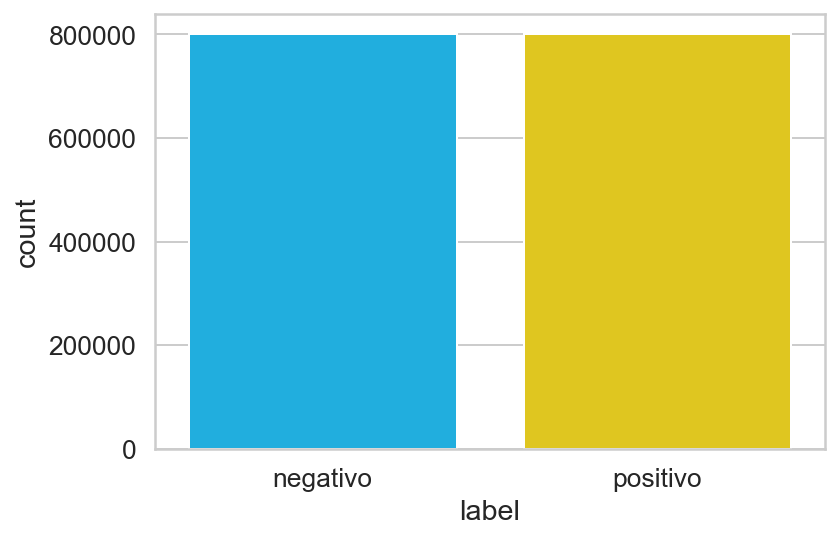

In [7]:
ax = sns.countplot(dados['label'])
class_names = ['negativo', 'positivo']
ax.set_xticklabels(class_names)

In [8]:
# Valores nulos
np.sum(dados.isnull().any(axis=1))

0

In [51]:
# Mudando o label dos positivos - de 4 para 1
dados['label'][dados['label']==4]=1

# Selecionado apenas os dados rotulados como positivo ou negativos - ignorando os dados não rotulados
pos = dados[dados['label'] == 1]
neg = dados[dados['label'] == 0]

print(f' Quantidade de dados positivos: {len(pos)}\n Quantidade de dados negativos: {len(neg)}')

 Quantidade de dados positivos: 800000
 Quantidade de dados negativos: 799999


### Construindo classificador de sentimento com BERT e PyTorch

In [52]:
# Selecionando apenas 1/4 do conjunto de dados para diminuir tempo de treinamento dos modelos - Undersampling

pos = pos.iloc[:int(20000)]
neg = neg.iloc[:int(20000)]

print(f' Quantidade de dados positivos: {len(pos)}\n Quantidade de dados negativos: {len(neg)}')

# Juntando dados positivos e negativos
dados = pd.concat([pos, neg])

# Selecionado apenas colunas com texto do tweet e seu rotulo
dados=dados[['text','label']]

 Quantidade de dados positivos: 20000
 Quantidade de dados negativos: 20000


In [53]:
# Separando base de dados em treinamento e teste
df_train, df_test = train_test_split(dados, test_size=0.2, random_state=RANDOM_SEED)

# Separando conjunto de teste em teste/validacao
df_test_BERT, df_eval_BERT = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
# Exemplo Tokenizador BERT

# tokenizador do BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# pegando um exemplo do dataset
txt_amostra = dados['text'].iloc[1]

tokens = tokenizer.tokenize(txt_amostra)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Texto: {txt_amostra}\n')
print(f'Tokens: {tokens}\n')
print(f'Token IDs: {token_ids}')

Texto: im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!

Tokens: ['im', 'meeting', 'up', 'with', 'one', 'of', 'my', 'best', '##ies', 'tonight', '!', 'Can', '##t', 'wait', '!', '!', '-', 'G', '##IR', '##L', 'T', '##AL', '##K', '!', '!']

Token IDs: [13280, 2309, 1146, 1114, 1141, 1104, 1139, 1436, 1905, 3568, 106, 2825, 1204, 3074, 106, 106, 118, 144, 18172, 2162, 157, 12507, 2428, 106, 106]


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


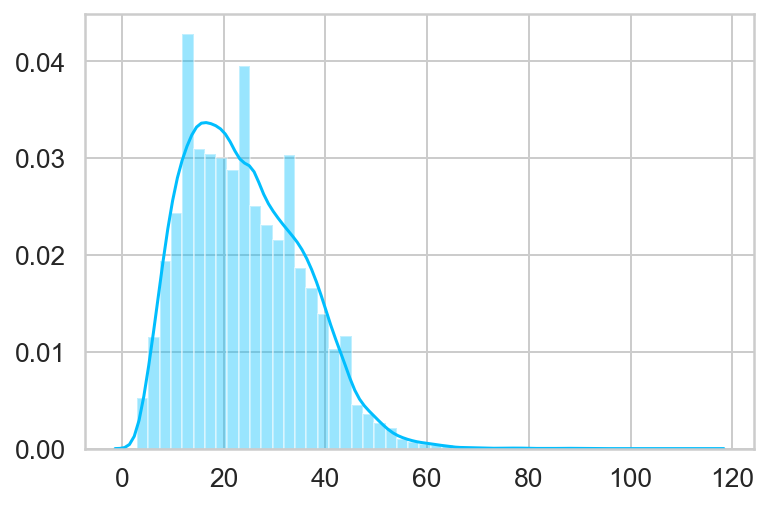

In [55]:
# Distribuiçao do tamanho dos tweets - sequence lenght - importante para criacao dos modelos

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokens_lens = []
for txt in dados['text']:
    tokens = tokenizer.encode(txt, max_length=512)
    tokens_lens.append(len(tokens))

sns.distplot(tokens_lens)

In [56]:
max_seq_length = 70

In [57]:
class GPReviewDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.tweets)
  
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          tweet,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': tweet,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [58]:
df = GPReviewDataset(
    tweets=df_train['text'].to_numpy(),
    targets=df_train['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_seq_length
  )

In [59]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        tweets=df['text'].to_numpy(),
        targets=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
      )

In [60]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, max_seq_length, BATCH_SIZE)
val_data_loader = create_data_loader(df_eval_BERT, tokenizer, max_seq_length, BATCH_SIZE)
test_data_loader = create_data_loader(df_test_BERT, tokenizer, max_seq_length, BATCH_SIZE)

In [61]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [62]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 70])
torch.Size([32, 70])
torch.Size([32])


In [63]:
bert_model = BertModel.from_pretrained('bert-base-cased')

class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        tuple_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        pooled_output = tuple_output[1]
        
        output = self.drop(pooled_output)
        return self.out(output)

In [64]:
model = SentimentClassifier(2)

In [65]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"]
        attention_mask = d["attention_mask"]
        targets = d["targets"]
        
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [66]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            targets = d["targets"]

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

        return correct_predictions.double() / n_examples, np.mean(losses)

In [67]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn, 
      device, 
      len(df_eval_BERT)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), f'best_model_state.bin')
        best_accuracy = val_acc

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Epoch 1/3
----------
Train loss 0.4700062430351973 accuracy 0.78278125
Val loss 0.38404927825927737 accuracy 0.82975

Epoch 2/3
----------
Train loss 0.29833284265547994 accuracy 0.8778125
Val loss 0.40469767433404924 accuracy 0.833

Epoch 3/3
----------
Train loss 0.17577204362861812 accuracy 0.93921875
Val loss 0.4939335290193558 accuracy 0.8265



In [68]:
model.load_state_dict(torch.load(f'best_model_state.bin'))

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test_BERT)
)

print(f'test acc: {test_acc.item()}')

test acc: 0.8215


In [69]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [71]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load(f'best_model_state.bin'))

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [75]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negativo       0.81      0.84      0.83      2013
    positivo       0.83      0.80      0.82      1987

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



### Construindo Classificador de sentimento com BERT - simpletransformers

In [40]:
# Selecionando apenas 1/40 do conjunto de dados para diminuir tempo de treinamento dos modelos - Undersampling

pos = pos.iloc[:int(2000)]
neg = neg.iloc[:int(2000)]

print(f' Quantidade de dados positivos: {len(pos)}\n Quantidade de dados negativos: {len(neg)}')

# Juntando dados positivos e negativos
dados = pd.concat([pos, neg])

# Selecionado apenas colunas com texto do tweet e seu rotulo
dados=dados[['text','label']]

 Quantidade de dados positivos: 2000
 Quantidade de dados negativos: 2000


In [41]:
# Separando base de dados em treinamento e teste
df_train, df_test = train_test_split(dados, test_size=0.2, random_state=RANDOM_SEED)

In [42]:
len(df_train), len(df_test)

(3200, 800)

In [43]:
# Configurando os hiperparametros do modelo
args = {'learning_rate':3e-5,
        'num_train_epochs': 1, 
        'reprocess_input_data': True, 
        'overwrite_output_dir': True,
        'max_seq_length': max_seq_length,
        'train_batch_size': 32,
        }


# Create a ClassificationModel
bert_model = ClassificationModel('bert', 'bert-base-cased', 
                                 num_labels=2, use_cuda=False, 
                                 args=args
                                )


bert_model.train_model(df_train)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/100 [00:00<?, ?it/s]

(100, 0.564028671681881)

In [44]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')


result, model_outputs, wrong_predictions = bert_model.eval_model(df_test, f1=f1_multiclass, acc=accuracy_score)
result

Running Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

{'mcc': 0.5540787464454735,
 'tp': 295,
 'tn': 325,
 'fp': 68,
 'fn': 112,
 'auroc': 0.854724259304412,
 'auprc': 0.8517501680760908,
 'f1': 0.775,
 'acc': 0.775,
 'eval_loss': 0.4855024354159832}